# Load package

In [1]:
%cd ..

In [2]:
import os
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import Layout
from IPython.display import display
import ipywidgets as widgets

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,6)
plt.rcParams["font.size"] = 17

In [5]:
from plasmistry.molecule import (H2_vib_group, CO_vib_group, CO2_vib_group)
from plasmistry.molecule import (H2_vib_energy_in_eV, H2_vib_energy_in_K,
                                 CO2_vib_energy_in_eV, CO2_vib_energy_in_K,
                                 CO_vib_energy_in_eV, CO_vib_energy_in_K)
from plasmistry.io import (LT_constructor, 
                           standard_Arr_constructor, 
                           chemkin_Arr_2_rcnts_constructor,
                           chemkin_Arr_3_rcnts_constructor,
                           eval_constructor,
                           reversed_reaction_constructor,
                           alpha_constructor,
                           Cros_Reaction_block, Coef_Reaction_block)
from plasmistry.reactions import (CrosReactions, CoefReactions)
from plasmistry.electron import EEDF
from plasmistry.electron import get_maxwell_eedf

In [6]:
import yaml
yaml.add_constructor(u"!eval", eval_constructor)
yaml.add_constructor(u"!LT", LT_constructor)
yaml.add_constructor("!StandardArr", standard_Arr_constructor)
yaml.add_constructor("!ChemKinArr_2_rcnt", chemkin_Arr_2_rcnts_constructor)
yaml.add_constructor("!ChemKinArr_3_rcnt", chemkin_Arr_3_rcnts_constructor)
yaml.add_constructor("!rev", reversed_reaction_constructor)
yaml.add_constructor("!alpha", alpha_constructor)

# Set widgets

In [7]:
_species_list = ['E', 'H2(v0-14)', 'CO2(v0-21)', 'CO(v0-10)', 'O2', 'H2O', 'H', 'O', 'OH']
_init_yaml_file_path = './_yaml/test_0.yaml'
_vari_dict = dict(H2_vib_energy_in_eV=H2_vib_energy_in_eV,
                  H2_vib_energy_in_K=H2_vib_energy_in_K,
                 CO2_vib_energy_in_eV=CO2_vib_energy_in_eV,
                 CO2_vib_energy_in_K=CO2_vib_energy_in_K)

# Load reactions


Reactions contains `electron reactions` and `relaxation reactions`



## functions
- `get_species_from_widgets`
- `load_reactions_from_widgets`
- `get_rctn_df_from_widgets`

In [8]:
rctn_considered = None
rctn_df = {'electron reactions': None, 'relaxation reactions': None}


def get_species_from_widgets(_event):
    print('set_species...', end=' ')
    species = []
    for _ in _widgets['species'].value:
        if _ == 'H2(v0-14)':
            species.append('H2')
            species.extend([f'H2(v{v})' for v in range(1, 15)])
        elif _ == 'CO2(v0-21)':
            species.append('CO2')
            species.extend([f'CO2(v{v})' for v in range(1, 22)])
        elif _ == 'CO(v0-10)':
            species.append('CO')
            species.extend([f'CO(v{v})' for v in range(11)])
        else:
            species.append(_)
    rctn_df['species'] = pd.Series(species)
    print('set done!')


# --------------------------------------------------------------------------- #


def load_reactions_from_widgets():
    with open(_widgets['path'].value, 'r') as f:
        rctn_block = yaml.load(f)
    return rctn_block[-1]['The reactions considered']


rctn_df = dict()


def get_rctn_df_from_widgets(_):
    print('loading...', end=' ')
    rctn_df['electron reactions'] = pd.DataFrame(
        columns=['formula', 'type', 'threshold_eV', 'cross_section'])
    rctn_df['relaxation reactions'] = pd.DataFrame(
        columns=['formula', 'type', 'reactant', 'product', 'kstr'])
    # ----------------------------------------------------------------------- #
    for _ in _widgets['ele'].value:
        _df = rctn_all['electron reactions'][_]
        _cros_block = Cros_Reaction_block(rctn_dict=_df, vari_dict=_vari_dict)
        if _ == 'H2_ele_dis_via_b':
            print('H2_ele_dis_via_b')
            factor = 1e-20
        else:
            factor = 1
        rctn_df['electron reactions'] = rctn_df['electron reactions'].append(
            _cros_block.generate_crostn_dataframe(factor=factor), 
            ignore_index=True)
    for _ in _widgets['rel'].value:
        _df = rctn_all['relaxation reactions'][_]
        _coef_block = Coef_Reaction_block(rctn_dict=_df, vari_dict=_vari_dict)
        rctn_df['relaxation reactions'] = rctn_df[
            'relaxation reactions'].append(
                _coef_block.generate_crostn_dataframe(), ignore_index=True)
    print('Get rctn_df done!')

# Set GUI

In [9]:
_widgets = dict()
_widgets['path'] = widgets.Text(value=_init_yaml_file_path)
display(widgets.HBox([widgets.HTML('<b>Yaml File Path</b>'),
                      _widgets['path']]))
rctn_all = load_reactions_from_widgets()
# --------------------------------------------------------------------------- #
# set select multiple
for _, _option in [('ele', rctn_all['electron reactions'].keys()),
                   ('rel', rctn_all['relaxation reactions'].keys()),
                   ('species', _species_list)]:
    _widgets[_] = widgets.SelectMultiple(options=_option,
                                         layout=Layout(height='900px'))
# --------------------------------------------------------------------------- #
# set floattext
for _, _value in [('electron_density', 1.0), ('Te', 1.0), ('CO2_density', 1.0),
                  ('CO2_Tvib', 1000), ('H2_density', 1.0), ('H2_Tvib', 1000),
                  ('CO_density', 1.0), ('CO_Tvib', 1000)]:
    _widgets[_] = widgets.FloatText(value=_value, layout=Layout(width='100px'))
# --------------------------------------------------------------------------- #
# set buttons
_button = dict()
_button['load reactions'] = widgets.Button(description='Load Reactions')
_button['set init-conditions'] = widgets.Button(
    description='Set init-conditions')

# --------------------------------------------------------------------------- #
display(
    widgets.HBox([
        widgets.VBox(
            [widgets.HTML('<b>ELECTRON REACTIONS:</b>'), _widgets['ele']]),
        widgets.VBox(
            [widgets.HTML('<b>RELAXATION REACTIONS:</b>'), _widgets['rel']]),
        widgets.VBox([widgets.HTML('<b>SPECIES</b>'), _widgets['species']])
    ]))
display(
    widgets.GridBox([
        widgets.HTML('<b>electron density</b>'), _widgets['electron_density'],
        widgets.HTML('<b>Te_eV</b>'), _widgets['Te'],
        widgets.HTML('<b>CO2_density</b>'), _widgets['CO2_density'],
        widgets.HTML('<b>CO2_Tvib</b>'), _widgets['CO2_Tvib'],
        widgets.HTML('<b>H2_density</b>'), _widgets['H2_density'],
        widgets.HTML('<b>H2_Tvib'), _widgets['H2_Tvib']
    ],
                    layout=widgets.Layout(
                        grid_template_columns="repeat(4, 20%)")))
display(
    widgets.HBox([_button['load reactions'], _button['set init-conditions']]))
_button['load reactions'].on_click(get_rctn_df_from_widgets)
_button['set init-conditions'].on_click(get_species_from_widgets)

GridBox(children=(HTML(value='<b>electron density</b>'), FloatText(value=1.0, layout=Layout(width='100px')), H…

loading... H2_ele_dis_via_b
Get rctn_df done!


C:\Users\PhyMan\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


set_species... set done!
loading... H2_ele_dis_via_b


C:\Users\PhyMan\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Get rctn_df done!


# Instance rctn_df

In [11]:
rctn_instances = {'electron reactions': None, 'relaxation reactions': None}


def from_rctn_df_to_cros_instance(_df):
    split_df = _df['formula'].str.split('\s*=>\s*', expand=True)
    reactant = split_df[0]
    product = split_df[1]
    return reactant, product


def from_rctn_df_to_coef_instance(_df):
    reactant = _df['reactant']
    product = _df['product']
    kstr = _df['kstr']
    return reactant, product, kstr


reactant, product = from_rctn_df_to_cros_instance(
    rctn_df['electron reactions'])
rctn_instances['electron reactions'] = CrosReactions(
    species=rctn_df['species'], reactant=reactant, product=product, k_str=None)
reactant, product, kstr = from_rctn_df_to_coef_instance(
    rctn_df['relaxation reactions'])
rctn_instances['relaxation reactions'] = CoefReactions(
    species=rctn_df['species'], reactant=reactant, product=product, k_str=kstr)
rctn_instances['relaxation reactions'].compile_k_str()
# rctn_instances['relaxation reactions'].set_rate_const(Tgas_K=1000, EN_Td=1, Te_eV=0)

In [12]:
eedf = EEDF(max_energy_eV=30, grid_number=300)
electron_energy_grid = eedf.energy_point
eedf.set_density_per_J(get_maxwell_eedf(eedf.energy_point, Te_eV=1.0))

In [13]:
rctn_instances['electron reactions'].set_rate_const_matrix(
    crostn_dataframe=rctn_df['electron reactions'],
    electron_energy_grid=electron_energy_grid)

# Start evolution

In [181]:
H2_percent_seq = [1, 0.93333, 0.88889, 0.83333, 0.77778, 0.66667, 0.5,
0.33333, 0.23077, 0.16667, 0.13043, 0.09091, 0.07407, 0.0566, 0.03, 0.01, 0]
time_end_seq = [0.38564, 0.46339, 0.58923, 0.66704, 0.69614, 0.8726, 0.97919, 
            1.01216, 1.05427, 1.14294, 1.06026, 1.11772, 1.13853, 1.17361,
            1.26435, 1.30063, 1.27632]
#### ====================
i_index = 16
H2_percent = H2_percent_seq[i_index]
time_end = time_end_seq[i_index] * 1e-3
#### =========================
y0 = rctn_instances['electron reactions'].get_initial_density(density_dict={
    'CO2': 2.4e24*(1-H2_percent),
    'H2': 2.4e24*H2_percent,
    'E': 1e19
}, min_density=1e1)

normalized_eedf = get_maxwell_eedf(eedf.energy_point, Te_eV=3.0)

def dndt_cros(t, y):
    _instance = rctn_instances['electron reactions']
    _instance.set_rate_const(eedf_normalized=normalized_eedf)
    _instance.set_rate(density=y)
    return _instance.get_dn()


def dndt_coef(t, y):
    _instance = rctn_instances['relaxation reactions']
    _instance.set_rate_const(Tgas_K=3500, EN_Td=1.0, Te_eV=3.0)
    _instance.set_rate(density=y)
    return _instance.get_dn()

def dndt_all(t, y):
    print(t)
    return dndt_cros(t, y) + dndt_coef(t, y)

In [182]:
time_span = (0, time_end)
sol = solve_ivp(dndt_all, time_span, y0, method='BDF', rtol=5e-2)

0.0
1.1003122759613904e-31
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.1003122759613904e-29
1.1003122759613904e-29
2.2006245519227807e-29
2.2006245519227807e-29
1.3203747311536685e-28
1.3203747311536685e-28
2.420687007115059e-28
2.420687007115059e-28
1.3423809766728965e-27
1.3423809766728965e-27
2.442693252634287e-27
2.442693252634287e-27
1.344581601224819e-26
1.344581601224819e-26
2.4448938771862095e-26
2.4448938771862095e-26
1.3448016636800113e-25
1.3448016636800113e-25
2.445113939641402e-25
2.445113939641402e-25
1.3448236699255308e-24
1.3448236699255308e-24
2.4451359458869212e-24
2.4451359458869212e-24
1.3448258705500826e-23
1.3448258705500826e-23
2.4451381465114732e-23
2.4451381465114732e-23
1.344826090612538e-22
1.344826090612538e-22
2.4451383665739288e-22
2.4451383665739288e-22
1.3448261126187

2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.0764388055537056e-06
2.076438805

0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.00015960572405372946
0.000159605

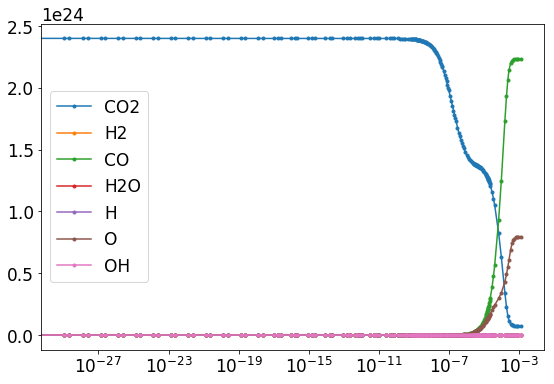

In [183]:
densities = dict()
for _ in ['CO2', 'H2', 'CO', 'H2O', 'H', 'O', 'OH']:
    densities[_] = sol.y[rctn_instances['electron reactions'].species==_].transpose()
    plt.semilogx(sol.t, densities[_], marker='.',label=_)
plt.legend()

In [184]:
rctn_instances['relaxation reactions'].set_rate(density=sol.y[:,-1])
rctn_instances['relaxation reactions'].view_rate_const_and_rate()

,formula,rate_const,rate
0,CO2(v1) + CO2 => CO2 + CO2,2.982733e-18,7.818968e+27
1,CO2(v2) + CO2 => CO2(v1) + CO2,3.404665e-18,5.720511e+27
2,CO2(v3) + CO2 => CO2(v2) + CO2,3.886284e-18,4.361008e+27
3,CO2(v4) + CO2 => CO2(v3) + CO2,4.436031e-18,3.147269e+27
4,CO2(v5) + CO2 => CO2(v4) + CO2,5.063544e-18,1.936962e+27
5,CO2(v6) + CO2 => CO2(v5) + CO2,5.779824e-18,1.086191e+27
6,CO2(v7) + CO2 => CO2(v6) + CO2,6.597428e-18,5.331433e+26
7,CO2(v8) + CO2 => CO2(v7) + CO2,7.530688e-18,2.180671e+26
8,CO2(v9) + CO2 => CO2(v8) + CO2,8.595964e-18,7.106029e+25
9,CO2(v10) + CO2 => CO2(v9) + CO2,9.811932e-18,1.822794e+25


In [185]:
rctn_instances['electron reactions'].set_rate(density=sol.y[:,-1])
rctn_instances['electron reactions'].view_rate_const_and_rate().sort_values(by='rate_const',ascending=False)

,formula,rate_const,rate
99,E + H2(v14) => E + H2(v13),2.217809e-13,4.091497e-14
49,E + H2(v13) => E + H2(v14),2.127670e-13,7.207330e-14
95,E + H2(v13) => E + H2(v12),1.795071e-13,6.080674e-14
47,E + H2(v12) => E + H2(v13),1.704926e-13,-1.101671e-13
91,E + H2(v12) => E + H2(v11),1.431449e-13,-9.249587e-14
44,E + H2(v11) => E + H2(v12),1.345994e-13,1.324010e-13
87,E + H2(v11) => E + H2(v10),1.122962e-13,1.104621e-13
40,E + H2(v10) => E + H2(v11),1.045386e-13,-3.146988e-13
83,E + H2(v10) => E + H2(v9),8.654299e-14,-2.605255e-13
36,E + H2(v9) => E + H2(v10),7.975936e-14,3.671423e-13


In [186]:
rctn_instances['electron reactions'].view_density(sol.y[:,-1]).sort_values(by='density', ascending=False)

,density,ratio
CO,2.233571e+24,57.1%
O,7.953849e+23,20.3%
O2,7.190929e+23,18.4%
CO2,7.318002e+22,1.9%
CO2(v1),3.582140e+22,0.9%
CO2(v2),2.295979e+22,0.6%
CO2(v3),1.533416e+22,0.4%
CO2(v4),9.694978e+21,0.2%
CO2(v5),5.227260e+21,0.1%
CO2(v6),2.568025e+21,0.1%


In [187]:
print(f"H2 percent: {H2_percent}")
print(f"time end:{time_end}")
# print(f"O:  {rctn_instances['electron reactions'].view_density(sol.y[:,-1]).loc['O', 'density']:.2e}")
# print(f"H:  {rctn_instances['electron reactions'].view_density(sol.y[:,-1]).loc['H', 'density']:.2e}")
# print(f"OH: {rctn_instances['electron reactions'].view_density(sol.y[:,-1]).loc['OH', 'density']:.2e}")
##########
# max density
print('H  O  OH  CO Tvib(CO2) Tvib(H2)')
print(f"{sol.y[rctn_instances['electron reactions'].species=='H'].max(): .2e}", end=' ')
print(f"{sol.y[rctn_instances['electron reactions'].species=='O'].max(): .2e}", end=' ')
print(f"{sol.y[rctn_instances['electron reactions'].species=='OH'].max():.2e}", end=' ')
_df = rctn_instances['electron reactions'].view_density(sol.y[:,-1])  
Tv_CO2 = -3380/np.log(_df.loc['CO2(v1)','density']/_df.loc['CO2','density'])
Tv_H2 = -5983/np.log(_df.loc['H2(v1)','density']/_df.loc['H2','density'])
print(f"{Tv_CO2:.0f}", end=' ')
print(f"{Tv_H2:.0f}", end=' ')

H2 percent: 0
time end:0.0012763199999999998
H  O  OH  CO Tvib(CO2) Tvib(H2)
 1.27e+02  7.95e+23 3.15e+02 4731 7158 

In [188]:
sol.y[rctn_instances['electron reactions'].species=='H'].max()

127.34192093659072

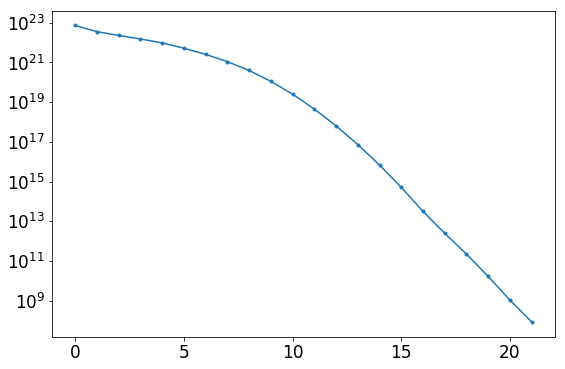

In [189]:
# plot CO2 vdf

x = ['CO2'] + [f'CO2(v{v})' for v in range(1, 22)]
y = [_df.loc[_,'density'] for _ in x]
plt.semilogy(range(22),y, marker='.')

In [190]:
Tv_CO2 = -3380/np.log(_df.loc['CO2(v1)','density']/_df.loc['CO2','density'])
Tv_H2 = -5983/np.log(_df.loc['H2(v1)','density']/_df.loc['H2','density'])
print(f"Tvib(CO2): {Tv_CO2:.0f} K")
print(f"Tvib(H2): {Tv_H2:.0f} K")

Tvib(CO2): 4731 K
Tvib(H2): 7158 K


In [191]:
y0

array([1.0e+19, 0.0e+00, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01,
       1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01,
       1.0e+01, 1.0e+01, 2.4e+24, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01,
       1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01,
       1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01,
       1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01,
       1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01,
       1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01, 1.0e+01])

def get_atom(_str):
    n_H = 0
    n_O = 0
    n_C = 0
    n_H += _str.count('H2')*2
    _str = _str.replace('H2','')
    n_H += _str.count('H')
    #
    n_O += _str.count('O2')*2
    _str = _str.replace('O2','')
    n_O += _str.count('O')
    n_C += _str.count('C')
    return (n_H, n_O, n_C)

In [192]:
rctn_instances['relaxation reactions'].formula

0            CO2(v1) + CO2 => CO2 + CO2
1        CO2(v2) + CO2 => CO2(v1) + CO2
2        CO2(v3) + CO2 => CO2(v2) + CO2
3        CO2(v4) + CO2 => CO2(v3) + CO2
4        CO2(v5) + CO2 => CO2(v4) + CO2
5        CO2(v6) + CO2 => CO2(v5) + CO2
6        CO2(v7) + CO2 => CO2(v6) + CO2
7        CO2(v8) + CO2 => CO2(v7) + CO2
8        CO2(v9) + CO2 => CO2(v8) + CO2
9       CO2(v10) + CO2 => CO2(v9) + CO2
10     CO2(v11) + CO2 => CO2(v10) + CO2
11     CO2(v12) + CO2 => CO2(v11) + CO2
12     CO2(v13) + CO2 => CO2(v12) + CO2
13     CO2(v14) + CO2 => CO2(v13) + CO2
14     CO2(v15) + CO2 => CO2(v14) + CO2
15     CO2(v16) + CO2 => CO2(v15) + CO2
16     CO2(v17) + CO2 => CO2(v16) + CO2
17     CO2(v18) + CO2 => CO2(v17) + CO2
18     CO2(v19) + CO2 => CO2(v18) + CO2
19     CO2(v20) + CO2 => CO2(v19) + CO2
20     CO2(v21) + CO2 => CO2(v20) + CO2
21             CO2(v1) + H2 => CO2 + H2
22         CO2(v2) + H2 => CO2(v1) + H2
23         CO2(v3) + H2 => CO2(v2) + H2
24         CO2(v4) + H2 => CO2(v3) + H2


In [84]:
rctn_instances['relaxation reactions'].k_str[112]

'(1.0)*((5.83e-13)*exp((-227)*Tgas**(-1/3)+(529)*Tgas**(-2/3)))*1'

In [85]:
rctn_instances['relaxation reactions'].k_str[126]

'(1.0)*((5.83e-13)*exp((-227)*Tgas**(-1/3)+(529)*Tgas**(-2/3)))*1*exp(-5983.227564760267/Tgas)'